## **Implement Advanced ML Algorithm for Classification**
**Dataset from BlackBoard:** Facial Emotion Recognition dataset

**File:** facial-emotion-recognition.zip (432.768 MB)

### **ToDo**
- Model eval: include professor + gr25 mugshots
- Try ResNet model
- Hyperparameter tuning
- Use proper loss/metrics standard in image classification
- Include early stopping
- Double check approach for base model fine tuning
- Comparability: use same imported metric on all algorithms
- Tag images with confidence %

In [6]:
# Step 1: Define the path to your local dataset
dataset_path = "/Users/thomas/Desktop/IT3212/assignment_4/thomas/facial-emotion-recognition/images"  # Replace this with the actual path to your dataset

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/thomas/miniconda3/envs/.machine_learning/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Epoch [1/15], Loss: 2.0936, Accuracy: 11.18%
Epoch [2/15], Loss: 2.0525, Accuracy: 24.34%
Epoch [3/15], Loss: 2.0288, Accuracy: 31.58%
Epoch [4/15], Loss: 2.0047, Accuracy: 40.79%
Epoch [5/15], Loss: 1.9723, Accuracy: 51.32%
Epoch [6/15], Loss: 1.9358, Accuracy: 61.84%
Epoch [7/15], Loss: 1.8946, Accuracy: 68.42%
Epoch [8/15], Loss: 1.8515, Accuracy: 76.32%
Epoch [9/15], Loss: 1.7998, Accuracy: 86.18%
Epoch [10/15], Loss: 1.7508, Accuracy: 88.82%
Epoch [11/15], Loss: 1.6971, Accuracy: 94.08%
Epoch [12/15], Loss: 1.6460, Accuracy: 97.37%
Epoch [13/15], Loss: 1.5933, Accuracy: 98.68%
Epoch [14/15], Loss: 1.5403, Accuracy: 98.68%
Epoch [15/15], Loss: 1.4799, Accuracy: 99.34%
              precision    recall  f1-score   support

       anger       1.00      0.95      0.97        19
    contempt       1.00      1.00      1.00        19
     disgust       1.00      1.00      1.00        19
        fear       1.00      1.00      1.00        19
       happy       0.95      1.00      0.97     

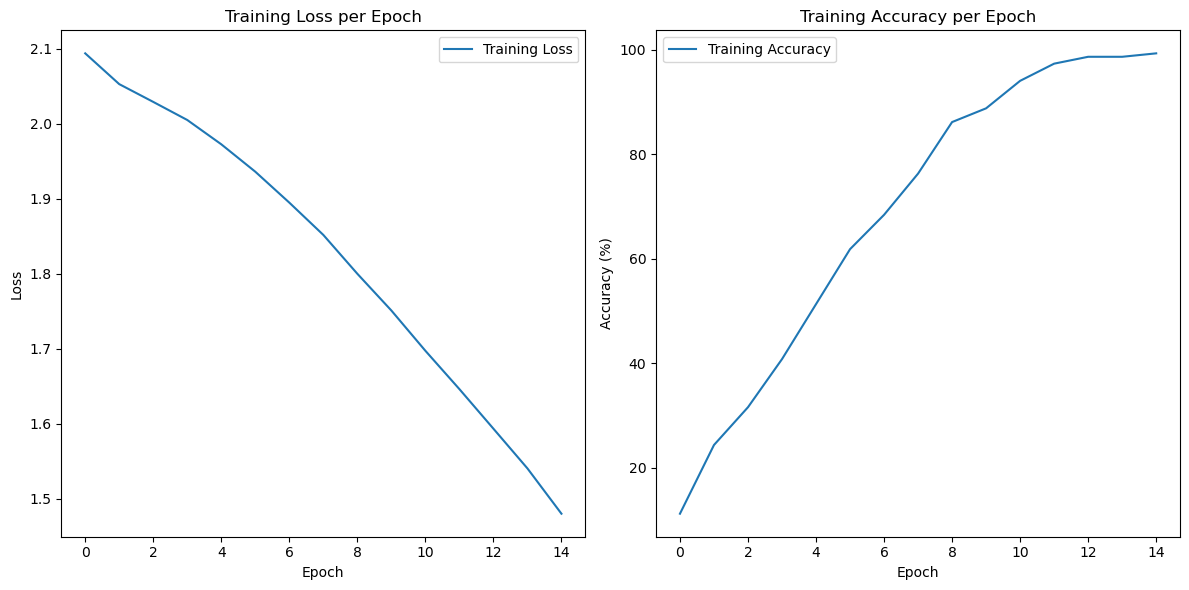

In [8]:
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch import nn, optim
from sklearn.metrics import classification_report

# Step 2: Load the dataset (assuming images are organized in folders by class)
train_dataset = datasets.ImageFolder(root=dataset_path, transform=transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the expected input size for ViT
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet standard normalization
]))

# Step 3: Load the pre-trained ViT model
model_name = "google/vit-base-patch16-224-in21k"  # You can try other models too
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(train_dataset.classes))
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# Step 4: Set up DataLoader for training
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Step 5: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Step 6: Fine-tuning the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 15

# Variables to track loss and accuracy
train_loss_history = []
train_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.logits, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / len(train_dataloader)
    accuracy = 100 * correct_predictions / total_predictions

    train_loss_history.append(avg_loss)
    train_acc_history.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Step 7: Evaluate the model
model.eval()
predictions = []
true_labels = []

for batch in train_dataloader:
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)

    preds = torch.argmax(outputs.logits, dim=1)
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(true_labels, predictions, target_names=train_dataset.classes))

# Step 8: Plot Training Loss and Accuracy
# Plot Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy per Epoch')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


## **With early stopping and validation**

In [11]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch import nn, optim
from sklearn.metrics import classification_report
from datasets import load_dataset
import torch

# Assuming images are organized by class in folders
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the expected input size for ViT
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
]))

# Step 2: Split dataset into train, validation, and test sets
train_size = int(0.8 * len(full_dataset))  # 80% training
test_size = len(full_dataset) - train_size  # 20% test
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Further split the training set into train and validation (10% validation)
train_size = int(0.9 * len(train_dataset))  # 90% for training
val_size = len(train_dataset) - train_size  # 10% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Step 3: Set up DataLoaders for training, validation, and testing
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# Step 4: Load the pre-trained ViT model
model_name = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(full_dataset.classes))
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# Step 5: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Step 6: Early Stopping Parameters
patience = 3  # Number of epochs to wait for improvement in validation loss before stopping
min_epochs_after_no_improvement = 5  # Minimum number of epochs to wait after no improvement before stopping
best_val_loss = float('inf')
epochs_without_improvement = 0

# Step 7: Training loop with Early Stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 50  # Max number of epochs

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training loop
    for batch in train_dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.logits, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculate average loss and training accuracy for the epoch
    avg_train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct_predictions / total_predictions

    train_loss_history.append(avg_train_loss)
    train_acc_history.append(train_accuracy)

    # Evaluate on the validation set
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.logits, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_predictions += labels.size(0)

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = 100 * val_correct_predictions / val_total_predictions

    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping logic with minimum epochs after no improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        # Save the model with the best validation loss
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"No improvement in validation loss for {patience} epochs. "
                  f"Waiting for {min_epochs_after_no_improvement} more epochs before stopping...")
            
            # Wait for minimum epochs to pass before actually stopping
            if epochs_without_improvement >= patience + min_epochs_after_no_improvement:
                print(f"Early stopping triggered at epoch {epoch+1}")
                #break

# Step 8: Load the best model (after early stopping)
model.load_state_dict(torch.load("best_model.pth"))

# Step 9: Evaluate on the test set
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)

    preds = torch.argmax(outputs.logits, dim=1)
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report on Test Set:")
print(classification_report(true_labels, predictions, target_names=full_dataset.classes))

# Step 10: Plot Training and Validation Loss, Accuracy
plt.figure(figsize=(18, 6))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(train_loss_history, label='Training Loss', color='red')
plt.plot(val_loss_history, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()

# Plot Training Accuracy
plt.subplot(1, 3, 2)
plt.plot(train_acc_history, label='Training Accuracy', color='red')
plt.plot(val_acc_history, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


ImportError: dlopen(/Users/thomas/miniconda3/envs/.machine_learning/lib/python3.12/site-packages/pyarrow/lib.cpython-312-darwin.so, 0x0002): Symbol not found: _BrotliDefaultAllocFunc
  Referenced from: <AE78991A-FDBC-355F-AE1F-B456D3A59B38> /Users/thomas/miniconda3/envs/.machine_learning/lib/libbrotlienc.1.1.0.dylib
  Expected in:     <751D82F8-ADA1-3A74-8E9B-C1B682F93468> /Users/thomas/miniconda3/envs/.machine_learning/lib/libbrotlicommon.1.0.7.dylib

NameError: name 'test_dataloader' is not defined

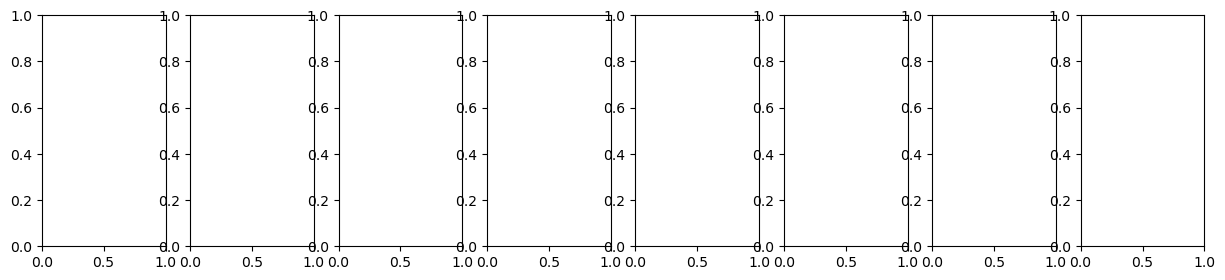

In [9]:
import numpy as np

# Step 10: Display some test images with predicted and ground truth labels
# Pick a few test images for visualization
num_images = 8
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

model.eval()  # Set the model to evaluation mode

for i, (images, labels) in enumerate(test_dataloader):
    print(i, num_images)
    if i >= num_images:  # Limit to num_images
        print('breaking')
        break
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)
        
        # Convert tensor to numpy for plotting
        image = images[0].cpu().numpy().transpose((1, 2, 0))  # CxHxW -> HxWxC
        image = (image * 0.229 + 0.485)  # Reverse the normalization
        image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1

        # Get the ground truth label
        true_label = full_dataset.classes[labels[0].item()]

        # Plot the image with both ground truth and predicted label in the title
        axes[i].imshow(image)
        axes[i].axis('off')  # Remove axes
        axes[i].set_title(f"GT: {true_label}\nPred: {full_dataset.classes[predicted[0]]}", fontsize=12)

plt.tight_layout()
plt.show()


NameError: name 'full_dataset' is not defined

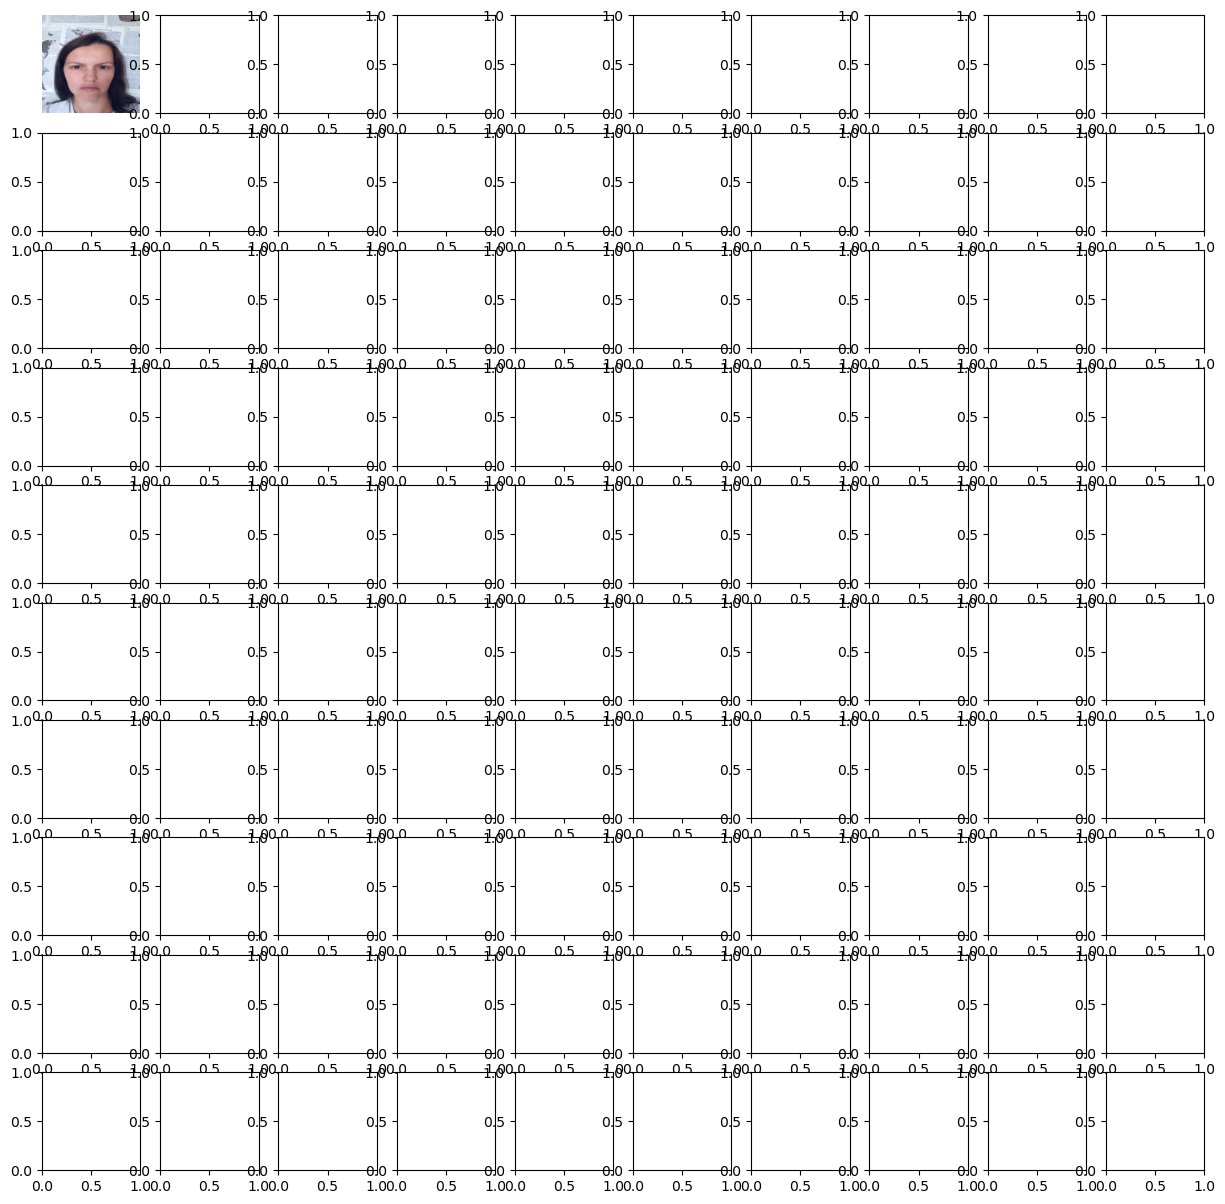

In [10]:
# Step 11: Dense Plot of All Training Images
# Create a dense grid of all training images
num_train_images = len(train_dataset)
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 15))  # Adjust the number of rows and columns as needed
axes = axes.flatten()

for i in range(num_train_images):
    image, label = train_dataset[i]
    image = image.cpu().numpy().transpose((1, 2, 0))  # CxHxW -> HxWxC
    image = (image * 0.229 + 0.485)  # Reverse the normalization
    image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1
    
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(full_dataset.classes[label], fontsize=8)

plt.tight_layout()
plt.suptitle('Training Images', fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

# Step 12: Dense Plot of All Test Images
# Create a dense grid of all test images
num_test_images = len(test_dataset)
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 15))  # Adjust the number of rows and columns as needed
axes = axes.flatten()

for i in range(num_test_images):
    image, label = test_dataset[i]
    image = image.cpu().numpy().transpose((1, 2, 0))  # CxHxW -> HxWxC
    image = (image * 0.229 + 0.485)  # Reverse the normalization
    image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1
    
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(full_dataset.classes[label], fontsize=8)

plt.tight_layout()
plt.suptitle('Test Images', fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/15], Train Loss: 2.0944, Train Accuracy: 13.89%, Validation Loss: 2.0614, Validation Accuracy: 15.38%
Epoch [2/15], Train Loss: 2.0497, Train Accuracy: 26.85%, Validation Loss: 2.0730, Validation Accuracy: 7.69%
Epoch [3/15], Train Loss: 2.0183, Train Accuracy: 34.26%, Validation Loss: 2.0879, Validation Accuracy: 0.00%
Epoch [4/15], Train Loss: 1.9859, Train Accuracy: 41.67%, Validation Loss: 2.1061, Validation Accuracy: 0.00%
No improvement in validation loss for 3 epochs. Waiting for 5 more epochs before stopping...
Epoch [5/15], Train Loss: 1.9482, Train Accuracy: 48.15%, Validation Loss: 2.1223, Validation Accuracy: 0.00%
No improvement in validation loss for 3 epochs. Waiting for 5 more epochs before stopping...
Epoch [6/15], Train Loss: 1.9096, Train Accuracy: 56.48%, Validation Loss: 2.1392, Validation Accuracy: 0.00%
No improvement in validation loss for 3 epochs. Waiting for 5 more epochs before stopping...
Epoch [7/15], Train Loss: 1.8652, Train Accuracy: 69.44%, Va

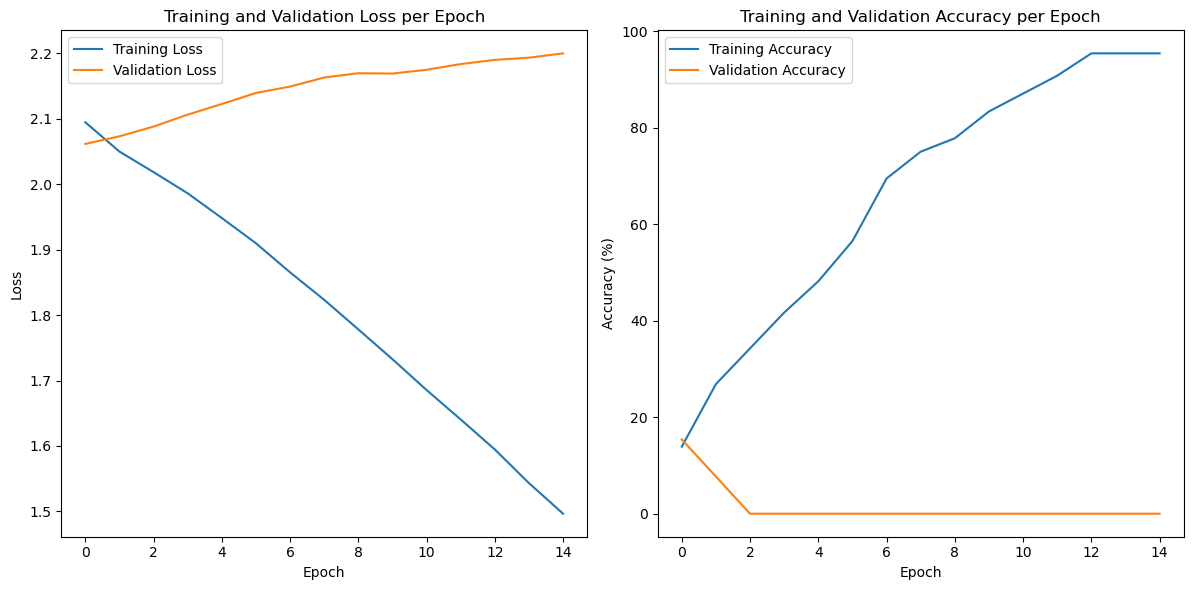

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import classification_report

# Step 1: Load the dataset
#dataset_path = "/path/to/your/local/dataset"  # Replace this with the actual path to your dataset

# Assuming images are organized by class in folders
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the expected input size for ViT
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
]))

# Step 2: Split dataset into train, validation, and test sets
train_size = int(0.8 * len(full_dataset))  # 80% training
test_size = len(full_dataset) - train_size  # 20% test
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Further split the training set into train and validation (10% validation)
train_size = int(0.9 * len(train_dataset))  # 90% for training
val_size = len(train_dataset) - train_size  # 10% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Step 3: Set up DataLoaders for training, validation, and testing
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 4: Load the pre-trained ViT model
model_name = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(full_dataset.classes))
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# Step 5: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Step 6: Early Stopping Parameters
patience = 3  # Number of epochs to wait for improvement in validation loss before stopping
min_epochs_after_no_improvement = 5  # Minimum number of epochs to wait after no improvement before stopping
best_val_loss = float('inf')
epochs_without_improvement = 0

# Step 7: Training loop with Early Stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 15  # Max number of epochs

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training loop
    for batch in train_dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.logits, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculate average loss and training accuracy for the epoch
    avg_train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct_predictions / total_predictions

    train_loss_history.append(avg_train_loss)
    train_acc_history.append(train_accuracy)

    # Evaluate on the validation set
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.logits, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_predictions += labels.size(0)

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = 100 * val_correct_predictions / val_total_predictions

    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping logic with minimum epochs after no improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        # Save the model with the best validation loss
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"No improvement in validation loss for {patience} epochs. "
                  f"Waiting for {min_epochs_after_no_improvement} more epochs before stopping...")
            
            # Wait for minimum epochs to pass before actually stopping
            if epochs_without_improvement >= patience + min_epochs_after_no_improvement:
                print(f"Early stopping triggered at epoch {epoch+1}")
                #break

# Step 8: Load the best model (after early stopping)
model.load_state_dict(torch.load("best_model.pth"))

# Step 9: Evaluate on the test set
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)

    preds = torch.argmax(outputs.logits, dim=1)
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report on Test Set:")
print(classification_report(true_labels, predictions, target_names=full_dataset.classes))

# Step 10: Plot Training and Validation Loss, Accuracy
plt.figure(figsize=(18, 6))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()

# Plot Training Accuracy
plt.subplot(1, 3, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


IndexError: index 100 is out of bounds for axis 0 with size 100

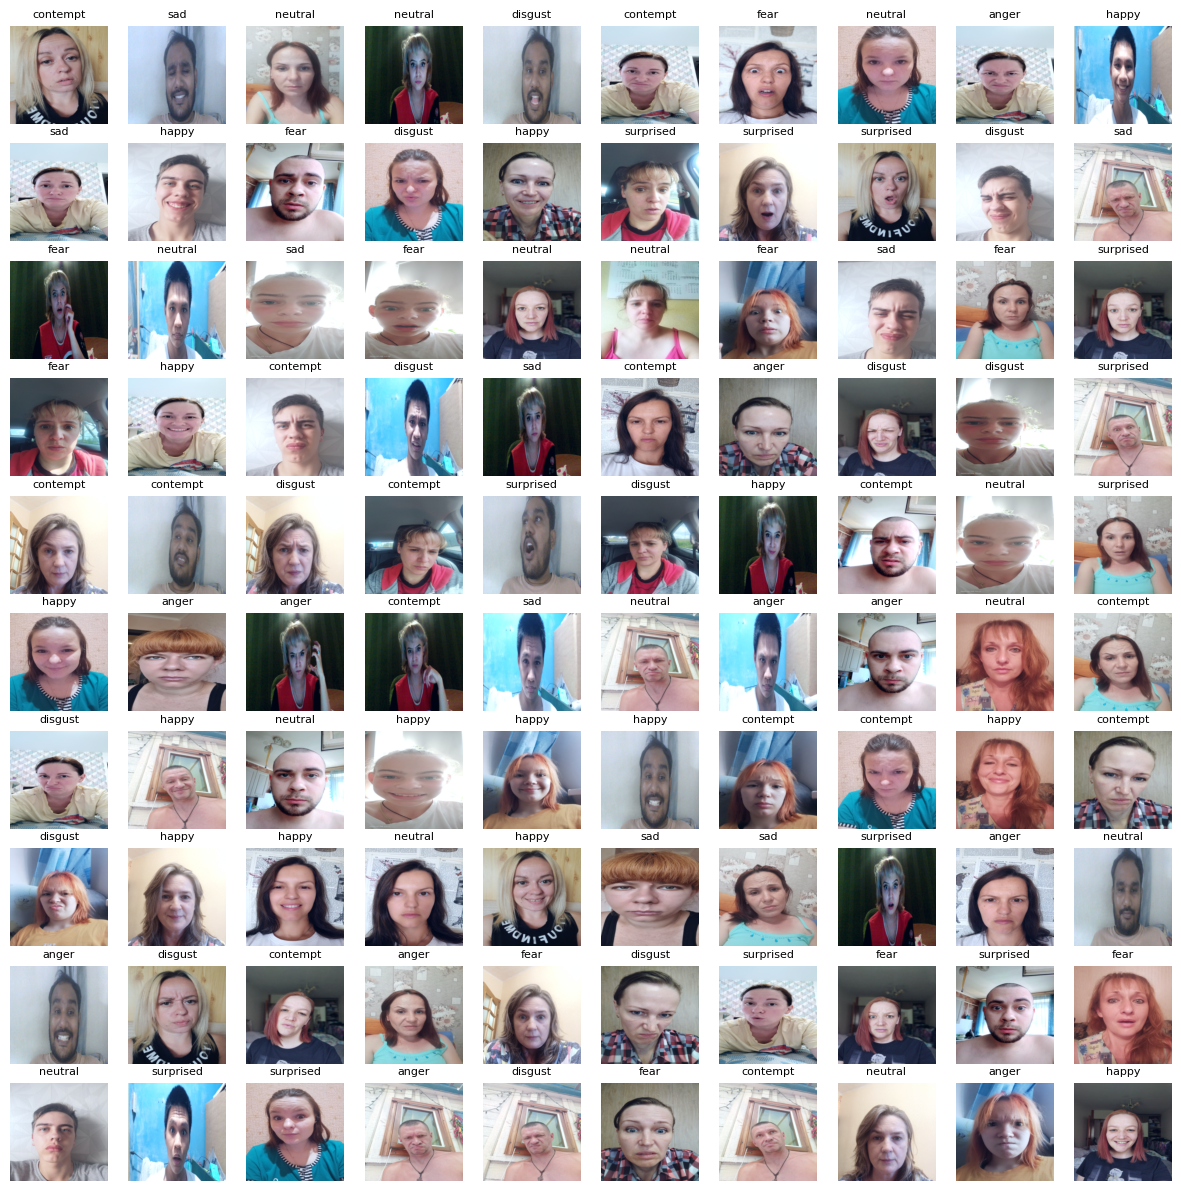

In [14]:
# Step 11: Dense Plot of All Training Images
# Create a dense grid of all training images
num_train_images = len(train_dataset)
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 15))  # Adjust the number of rows and columns as needed
axes = axes.flatten()

for i in range(num_train_images):
    image, label = train_dataset[i]
    image = image.cpu().numpy().transpose((1, 2, 0))  # CxHxW -> HxWxC
    image = (image * 0.229 + 0.485)  # Reverse the normalization
    image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1
    
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(full_dataset.classes[label], fontsize=8)

plt.tight_layout()
plt.suptitle('Training Images', fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

# Step 12: Dense Plot of All Test Images
# Create a dense grid of all test images
num_test_images = len(test_dataset)
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 15))  # Adjust the number of rows and columns as needed
axes = axes.flatten()

for i in range(num_test_images):
    image, label = test_dataset[i]
    image = image.cpu().numpy().transpose((1, 2, 0))  # CxHxW -> HxWxC
    image = (image * 0.229 + 0.485)  # Reverse the normalization
    image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1
    
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(full_dataset.classes[label], fontsize=8)

plt.tight_layout()
plt.suptitle('Test Images', fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()